# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density?

### Objectives

* Describe how **Variants** describe values that vary with the timestep.
* Show how to use **BoxResize** with a **Ramp variant** to slowly compress the system to the target volume.
* Demonstrate the crystallization of Lennard-Jones particles

## Boilerplate code

In [1]:
import hoomd
import fresnel
import math
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

The `render` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=430, h=430)

def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene, N=len(snapshot.particles.position), radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
                    fresnel.light.Light(direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3)]
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    scene.background_color = (1,1,1)
    return tracer.sample(scene, samples=1000)

## Procedure

`random.gsd`, generated by the previous section of this tutorial has particles randomly placed in a low density fluid state.
To find the crystalline state, you need to compress the system to a higher density.
If you were to immediately scale the system to the target density, the particle's hard cores would overlap and the integrator would be come unstable.
A more effective strategy gradually resizes the simulation box a little at a time over the course of a simulation, allowing any slight overlaps to relax.

## Initialize the simulation

Configure this simulation to run on the GPU:

In [3]:
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu)
sim.create_state_from_gsd(filename='random.gsd')

Set up the molecular dynamics simulation, as discussed in the previous sections of this tutorial:

In [4]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

## Variants

The **BoxResize** class performs the gradual changes to the simulation box.
You provide a **Variant** that tells **BoxResize** how to interpolate between two boxes, `box1` and `box2`, over time.
A **Variant** is a scalar-valued function of the simulation timestep.
**BoxResize** sets `box1` when the function is at its minimum, `box2` when the function is at its maximum, and linearly interpolates between the two boxes for intermediate values.

Use the **Ramp variant** to define a function that ramps from one value to another over a given number of steps.
Note that this simulation does not start at timestep 0, `random.gsd` was saved after running a number of steps to randomize the system in the previous section:

In [5]:
sim.timestep

30000

Create a **Ramp** that starts at this step and ends 100,000 steps later:

In [6]:
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=100000)

Here is what the ramp looks like as a function of timestep:

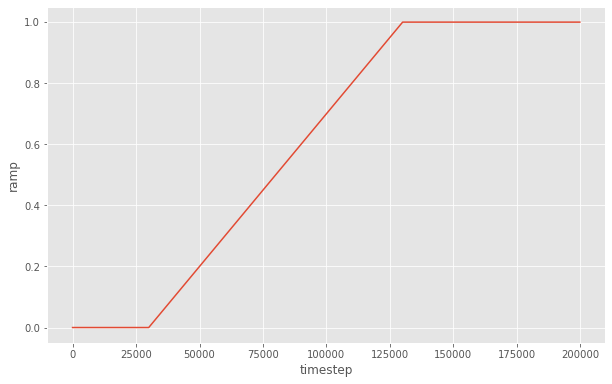

In [7]:
steps = range(0, 200000, 200)
y = [ramp(step) for step in steps]

fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('ramp')
fig

## Gradually resize the simulation box

Now, you need to determine the initial simulation box `box1` and final simulation box at the target density `box2`.
Here is the number density $\rho$ of the current simulation box:

In [8]:
rho = sim.state.N_particles / sim.state.box.volume
rho

0.7337058125475103

The initial configuration looks like this:

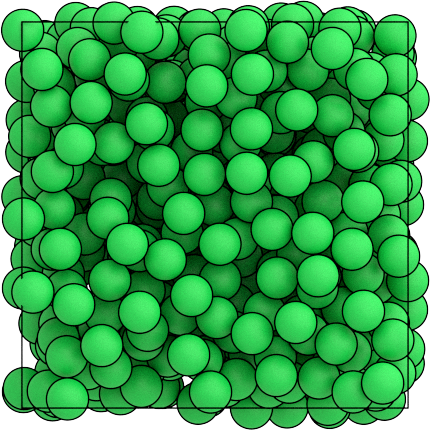

In [9]:
render(sim.state.snapshot)

Create a new **Box** at the target number density:

In [10]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box) # make a copy of initial_box
final_rho = 1.2
final_box.volume = sim.state.snapshot.particles.N / final_rho

To avoid destabilizing the integrator with large forces due to large box size changes, the box should be resized with a small period.

In [11]:
box_resize_trigger = hoomd.trigger.Periodic(10)

Construct the **BoxResize updater** and add it to the simulation.

In [12]:
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)

Run the simulation to compress the box.

In [13]:
sim.run(50001)

At the half way point of the ramp, the variant should be 0.5 and the current box lengths should be half way between the initial and final ones:

In [14]:
ramp(sim.timestep-1)

0.5

In [15]:
current_box = sim.state.box
(current_box.Lx - initial_box.Lx) / (final_box.Lx - initial_box.Lx)

0.5000000000000003

Finish the rest of the compression:

In [16]:
sim.run(50000)

The current box should now match the final box:

In [17]:
sim.state.box == final_box

True

The system should now be at a higher density:

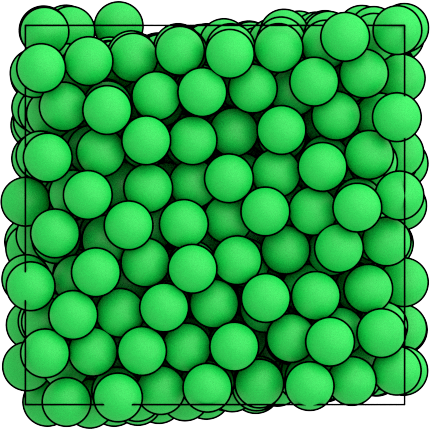

In [18]:
render(sim.state.snapshot)

Now that the system has reached the target volume, you can remove the **BoxResize** updater from the simulation:

In [19]:
sim.operations.updaters.remove(box_resize)

## Equilibrating the system

Run the simulation for a longer time and see if it self assembles the ordered fcc structure:
<div class="alert alert-warning">
This cell may require hours to complete.
</div>

In [20]:
sim.run(2e6)

Here is what the final state of the system looks like:

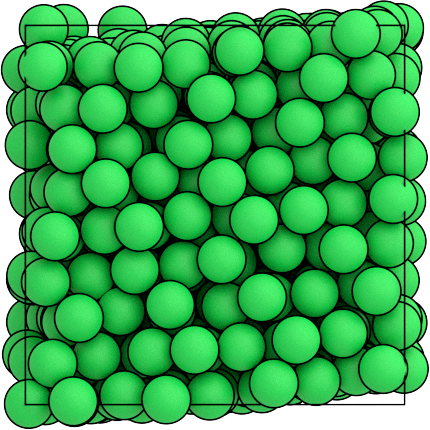

In [21]:
render(sim.state.snapshot)

## Analyzing the simulation results

Is this the fcc structure? Did the system reach equilibrium? These are topics covered in the [Introducing HOOMD-blue](../00-Introducing-HOOMD-blue/index.ipynb) tutorial. Consider it an exercise to modify this example and implement that analysis here. You will need to save a GSD file with the simulation trajectory, then use freud's **SolidLiquid** order parameter to identify when the ordered structure appears.

This is the end of the introducing molecular dynamics tutorial! It described molecular dynamics simulations, demonstrated how to initialize, randomize, compress, and equilibrate a system of Lennard-Jones particles. See the other HOOMD-blue tutorials to learn about other concepts, or browse the reference documentation for more information.

[Previous section](02-Initializing-a-Random-System.ipynb).